In [14]:
from gekko import GEKKO
import numpy as np
import matplotlib.pyplot as plt

m = GEKKO()

## This model simulates the distillation of a ternary mixture of methanol, water and acetone in a column with $n$ stages via assumption of thermodynamic equillibrium on every stage. The mixture is introduced at stage $fstage$.

In [15]:
nk = 3

comps = ["Methanol", "Water", "Acetone"]

compcolors = ["green", "blue", "black"]

nstages = 30 #number of equillibrium stages, condenser being 0 

fstage = 12 #number of feedtray

stages = np.arange(0,nstages,1)



"""Antoine Constants"""

A = list(range(nk))
A[0] = 8.08097
A[1] = 8.07131
A[2] = 7.1327

B = list(range(nk))
B[0] = 1582.27
B[1] = 1730.63
B[2] = 1219.97

C = list(range(nk))
C[0] = 239.7
C[1] = 233.426
C[2] = 230.653

   
"""Methanol"""

se_A = m.Const(-238.4e3) #standard heat of formation at 25°C and 1 atm

hvap_A = m.Const(37.6e3) #heat of vaporization

cp_LA =m.Const(value=80.4) #liquid heat capacity

cp_VA = m.Const(44.08) #vapor heat capcity

"""Wasser"""

se_B = m.Const(-285.830e3) #standard heat of formation at 25°C and 1 atm

hvap_B = m.Const(40.65e3) #heat of vaporization

cp_VB = m.Const(37.1) #liquid heat capacity

cp_LB = m.Const(77.5) #vapor heat capcity


"""Acetone"""

se_C = m.Const(-218.5e3) #standard heat of formation at 25°C and 1 atm

hvap_C = m.Const(31.27e3) #heat of vaporization

cp_VC = m.Const(75.32) #vapor heat capcity

"""Betriebsparameter"""


p = m.Const(value = 1.01325e5) #Column pressure

F = m.Const(value=8)   #Feed flow rate in mol/s

T_F = m.Var(value = 85, lb=50, ub=105) #Temperature of feed in °C

z = list(range(nk))

z[0] = m.Const(value = 0.5) #mole fraction of Methanol
z[2] = m.Const(value = 0.25) #mole fraction of Acetone



"""Betriebsvariablen"""

z[1] = m.Var(value=0.5, lb=0, ub=1)

Q_cond = m.Var(value = 110e3)

Q_reb = m.Var(value = 150e3)

RR = m.Const(value=2.3)#, lb=0.001, ub=40)

BR = m.Const(value=1.8)#, lb=0.001, ub=40)#, lb=0.001, ub=40)   

L = [m.Var(value=5, lb=0) for i in range(nstages)]

V = [m.Var(value=5, lb=0) for i in range(nstages)]


x = list(range(nk))
for c in range(nk):
    x[c] = [m.Var(value=0.5, lb=0, ub=1) for i in range(nstages)]


y = list(range(nk))
for c in range(nk):
    y[c] = [m.Var(value=0.5, lb=0, ub=1) for i in range(nstages)]


h_F = m.Var(value = 200e3)


T = [m.Var(value = 80, lb=50, ub=105) for i in range(nstages)]

p_sat = list(range(nk))
for c in range(nk):
    p_sat[c] = [m.Var(value = 9e4, lb=0) for i in range(nstages)]


h_L = [m.Var(value = 200e3) for i in range(nstages)]
h_V = [m.Var(value = 240e3) for i in range(nstages)]




"""Mixture properties"""

#Calculation of feed boiling point and enthalpy of saturated liquid feed

m.Equation(p == z[0]*(10**(A[0]-(B[0] /(T_F+C[0]))))*133.322 
                + z[1]*(10**(A[1]-(B[1]/(T_F+C[1]))))*133.322
                + z[2]*(10**(A[2]-(B[2]/(T_F+C[2]))))*133.322)

m.Equation(h_F == z[0]*(se_A + cp_VA*(T_F -25) -hvap_A) 
                        +z[1]*(se_B + cp_VB*(T_F -25) - hvap_B)
                        +z[2]*(se_C + cp_VC*(T_F -25) - hvap_C))

#Calculation of component saturation pressures

for c in range(nk):
    m.Equations([p_sat[c][i] == (10**(A[c]-(B[c]/(T[i]+C[c]))))*133.322  for i in range(nstages)])


#Calculation of vapor and liquid enthalpies

m.Equations([h_V[i] == y[0][i]*(se_A + cp_VA*(T[i] -25)) 
                        +y[1][i]*(se_B + cp_VB*(T[i] -25))
                        + y[2][i]*(se_C + cp_VC*(T[i] -25)) for i in range(nstages)])


m.Equations([h_L[i] == x[0][i]*(se_A + cp_VA*(T[i] -25) -hvap_A) 
                        +x[1][i]*(se_B + cp_VB*(T[i] -25) -hvap_B)
                        +x[2][i]*(se_C + cp_VC*(T[i] -25) -hvap_C) for i in range(nstages)])



"""Condenser balances"""


#mass balance

m.Equation(0 == V[1] - V[0] - L[0])

#species balance A

for c in range(nk-1):
    m.Equation(0 == V[1]*y[c][1] - L[0]*x[c][0] - V[0]*y[c][0])


#Energy balance

m.Equation(0 == V[1]*h_V[1] - L[0]*h_L[0] - V[0]*h_V[0] - Q_cond) 


m.Equation(L[0]*RR == V[0]) #Reflux Ratio



#Evaporator


m.Equation(BR*V[nstages-1] == L[nstages-1])


#Mass balance

m.Equation(0 == L[nstages-2] - V[nstages-1] - L[nstages-1])

#Species balance 
for c in range(nk-1):
    m.Equation(0 == L[nstages-2]*x[c][nstages-2] - V[nstages-1]*y[c][nstages-1] - L[nstages-1]*x[c][nstages-1])



#Energy balance

m.Equation(0 == Q_reb + L[nstages-2]*h_L[nstages-2] 
                - V[nstages-1]*h_V[nstages-1] - L[nstages-1]*h_L[nstages-1])





"""Kolonne"""

#Gesamtbilanz

m.Equations([0 == V[i+1] - V[i] + L[i-1] - L[i] for i in range(1,fstage)])

m.Equation(0 == F + V[fstage+1] - V[fstage] + L[fstage-1] - L[fstage])

m.Equations([0 == V[i+1] - V[i] + L[i-1] - L[i] for i in range(fstage+1, nstages-1)])



for c in range(nk-1):
    
    #species balance A rectifying section
    
    m.Equations([0 == V[i+1]*y[c][i+1] - V[i]*y[c][i] + L[i-1]*x[c][i-1] - L[i]*x[c][i] 
                     for i in range(1,fstage)])
    
    #species balance feed stage
    
    m.Equation(0 == F*z[c] + V[fstage+1]*y[c][fstage+1] - V[fstage]*y[c][fstage] 
                + L[fstage-1]*x[c][fstage-1] - L[fstage]*x[c][fstage])
    
    m.Equations([0 == V[i+1]*y[c][i+1] - V[i]*y[c][i] + L[i-1]*x[c][i-1] - L[i]*x[c][i] 
                     for i in range(fstage+1, nstages-1)])





#Energy balance rectifying section

m.Equations([0 == V[i+1]*h_V[i+1] - V[i]*h_V[i] + L[i-1]*h_L[i-1] - L[i]*h_L[i]
                    for i in range(1,fstage)])

#Energy balance feed stage

m.Equation(0 == F*h_F + V[fstage+1]*h_V[fstage+1] - V[fstage]*h_V[fstage] 
                + L[fstage-1]*h_L[fstage-1] - L[fstage]*h_L[fstage])

#Energy balance stripping section
m.Equations([0 == V[i+1]*h_V[i+1] - V[i]*h_V[i] + L[i-1]*h_L[i-1] - L[i]*h_L[i]
                    for i in range(fstage+1, nstages-1)])



#Summation condition


m.Equations([1 == x[0][i] + x[1][i] + x[2][i] for i in range(nstages)])
m.Equations([1 == y[0][i] + y[1][i] + y[2][i] for i in range(nstages)])
m.Equation(1 == np.sum(z))


#Equillibrium condition for ideal gas and ideal liquid mixture

for c in range(nk):
    m.Equations([p*y[c][i] == p_sat[c][i]*x[c][i]  for i in range(nstages)])


In [16]:
m.solve(disp=False)

Required reflux ratio: 2.3
Required boilup ratio: 1.8
x_A[0] [0.65328134743]
y_A[1] [0.60813427919]


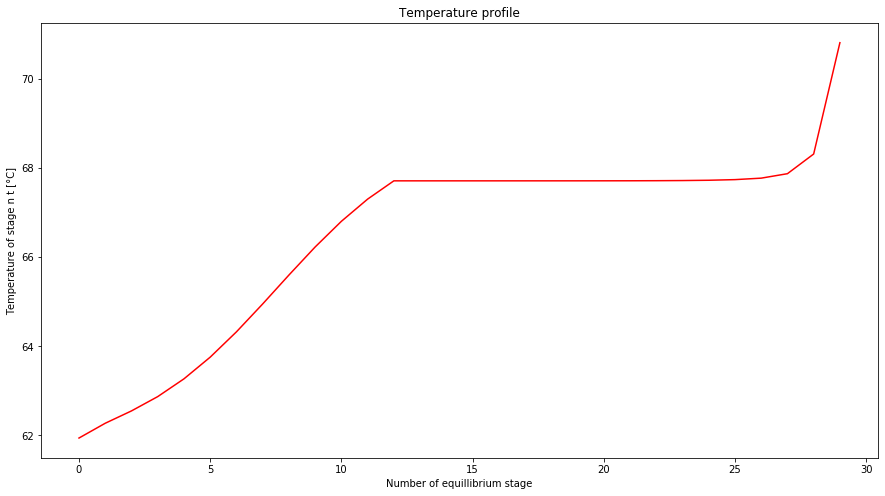

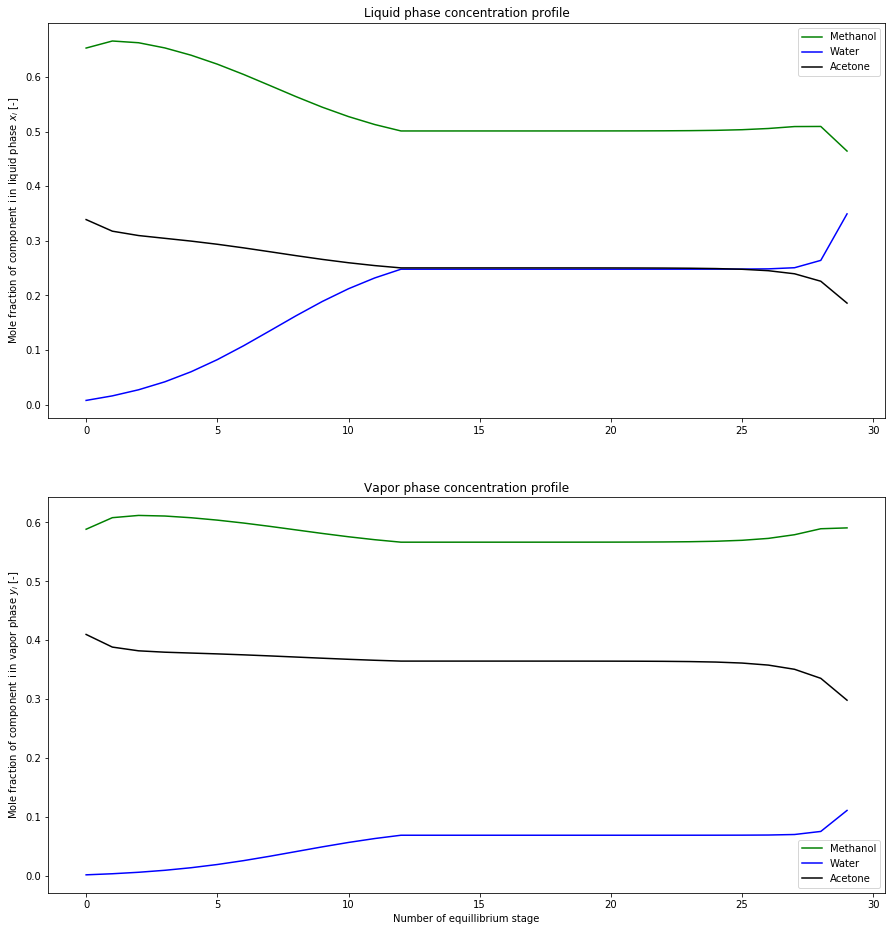

In [17]:
print("Required reflux ratio:", RR.Value)
print("Required boilup ratio:", BR.Value)
print("x_A[0]", x[0][0].Value)
print("y_A[1]", y[0][1].Value)

plt.figure(figsize=(15,8))
plt.title("Temperature profile")
plt.ylabel("Temperature of stage n t [°C]")
plt.xlabel("Number of equillibrium stage")
plt.plot(stages, T, color="red")

plt.figure(figsize=(15,16))
plt.subplot(211)
plt.title("Liquid phase concentration profile")
plt.ylabel("Mole fraction of component i in liquid phase $x_i$ [-]")
for c in range(nk):
    plt.plot(stages, x[c], label=comps[c], color=compcolors[c])
plt.legend(loc="best")

plt.subplot(212)
plt.title("Vapor phase concentration profile")
plt.ylabel("Mole fraction of component i in vapor phase $y_i$ [-]")
plt.xlabel("Number of equillibrium stage")
for c in range(nk):
    plt.plot(stages, y[c], label=comps[c], color=compcolors[c])    
plt.legend(loc="best")
